## Comparing CHIME admission predictions to our actual admit data
We've been using [CHIME](https://github.com/CodeForPhilly/chime) model since its early release days and have been trying to tailor things for our specific needs. We have had hospital administrators express concern due to the "census=0 at time=0" problem and were excited to see the model enhancement addressing this became available on the `develop` branch yesterday. The approach taken seems really solid and it's nice (from a UI perspective) that it only requires on additional input.

So, I took our actual admits (from 2/20/2020 to a few days ago) and just fit an exponential growth model, got the implied growth rate and implied doubling time. Plotted actual admits vs predicted (just using simple exp growth model) and got very nice fit. Then used implied doubling time of 3.61 in CHIME model and our other hospital specific inputs (market share and population) and got very nice match with the exponential fit to admits and thus, to the actual admits. Everyone super happy to see this!

The rest of this notebook includes:

* the actual admits by date data, 
* our CHIME input files,
* the comparisons of our actual with CHIME prediction,
* our plans going forward with respect to covid modeling/analysis.

In [359]:
# from argparse import (
#     Action,
#     ArgumentParser,
# )

# from datetime import datetime

# from penn_chime.settings import DEFAULTS
# from penn_chime.parameters import Parameters, RateDays
# from penn_chime.models import SimSirModel


import numpy as np
import pandas as pd
from pandas import Timestamp
import json
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [360]:
%matplotlib inline

## Fit exponential growth model to our admits by date
As we are yet to hit capacity (getting close) and are still in the exponential growth phase, I'm going to:

* fit an exponential growth model to our admits by date for 2020-02-20 - 2020-03-25)
* use fitted growth parameter to compute our doubling time,
* use that doubling time in the new CHIME model
* also use new CHIME model with our actual date of first admit
* compare fits of CHIME model projections to our actual admit by date data

Here are our actual admits by date.

In [361]:
# actual_df = pd.read_csv("act_admits_20200220.csv", parse_dates = ['date'])
actual_df = pd.DataFrame({'date': {0: Timestamp('2020-02-20 00:00:00'),
  1: Timestamp('2020-02-21 00:00:00'),
  2: Timestamp('2020-02-22 00:00:00'),
  3: Timestamp('2020-02-23 00:00:00'),
  4: Timestamp('2020-02-24 00:00:00'),
  5: Timestamp('2020-02-25 00:00:00'),
  6: Timestamp('2020-02-26 00:00:00'),
  7: Timestamp('2020-02-27 00:00:00'),
  8: Timestamp('2020-02-28 00:00:00'),
  9: Timestamp('2020-02-29 00:00:00'),
  10: Timestamp('2020-03-01 00:00:00'),
  11: Timestamp('2020-03-02 00:00:00'),
  12: Timestamp('2020-03-03 00:00:00'),
  13: Timestamp('2020-03-04 00:00:00'),
  14: Timestamp('2020-03-05 00:00:00'),
  15: Timestamp('2020-03-06 00:00:00'),
  16: Timestamp('2020-03-07 00:00:00'),
  17: Timestamp('2020-03-08 00:00:00'),
  18: Timestamp('2020-03-09 00:00:00'),
  19: Timestamp('2020-03-10 00:00:00'),
  20: Timestamp('2020-03-11 00:00:00'),
  21: Timestamp('2020-03-12 00:00:00'),
  22: Timestamp('2020-03-13 00:00:00'),
  23: Timestamp('2020-03-14 00:00:00'),
  24: Timestamp('2020-03-15 00:00:00'),
  25: Timestamp('2020-03-16 00:00:00'),
  26: Timestamp('2020-03-17 00:00:00'),
  27: Timestamp('2020-03-18 00:00:00'),
  28: Timestamp('2020-03-19 00:00:00'),
  29: Timestamp('2020-03-20 00:00:00'),
  30: Timestamp('2020-03-21 00:00:00'),
  31: Timestamp('2020-03-22 00:00:00'),
  32: Timestamp('2020-03-23 00:00:00'),
  33: Timestamp('2020-03-24 00:00:00'),
  34: Timestamp('2020-03-25 00:00:00')},
 'act_occ': {0: 1,
  1: 1,
  2: 1,
  3: 1,
  4: 1,
  5: 2,
  6: 2,
  7: 2,
  8: 2,
  9: 2,
  10: 2,
  11: 3,
  12: 3,
  13: 3,
  14: 4,
  15: 6,
  16: 6,
  17: 6,
  18: 6,
  19: 6,
  20: 6,
  21: 11,
  22: 18,
  23: 28,
  24: 37,
  25: 62,
  26: 89,
  27: 124,
  28: 182,
  29: 238,
  30: 287,
  31: 352,
  32: 461,
  33: 572,
  34: 658},
 'act_admits': {0: 1,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 1,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 1,
  12: 0,
  13: 0,
  14: 1,
  15: 2,
  16: 0,
  17: 0,
  18: 0,
  19: 0,
  20: 0,
  21: 5,
  22: 7,
  23: 10,
  24: 9,
  25: 25,
  26: 29,
  27: 44,
  28: 67,
  29: 66,
  30: 71,
  31: 82,
  32: 128,
  33: 152,
  34: 143}})


Get x and y for model fitting

In [362]:
x = np.array(actual_df.index)
y = np.array(actual_df['act_admits'])

### Play around with curve_fit from scipy
Trying a few values for initial parameter values. Seems getting stable estimates.

In [363]:
curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(.1, 0.10))

(array([0.16092407, 0.20405034]),
 array([[ 0.00359308, -0.00069334],
        [-0.00069334,  0.00013456]]))

In [364]:
curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(.2, 0.10))

(array([0.16092363, 0.20405043]),
 array([[ 0.00359317, -0.00069335],
        [-0.00069335,  0.00013456]]))

In [365]:
curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(1, 0.10))

(array([0.16093004, 0.20404919]),
 array([[ 0.00359197, -0.00069325],
        [-0.00069325,  0.00013457]]))

In [366]:
curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(.1, 0.30))

(array([0.16093264, 0.20404868]),
 array([[ 0.00359148, -0.00069321],
        [-0.00069321,  0.00013457]]))

### Fit model simple exp growth model to our admits
Want to see what our intrinsic admit growth rate looks like.

In [367]:
# Function to fit
def func(x, a, b, c):
     return a * np.exp(b * x) + c

Do the fit and compute quantities of interest.

In [368]:
popt, pcov = curve_fit(func, x, y,  p0=(1, 0.10, 0))
print(popt)
intrinsic_growth_rate_adm = popt[1]
implied_doubling_time = np.log(2.0) / intrinsic_growth_rate_adm
print("intrinsic_growth_rate_adm = {:3f}".format(intrinsic_growth_rate_adm))
print("implied_doubling_time = {:3f}".format(implied_doubling_time))

[ 0.24566128  0.19192493 -3.27540411]
intrinsic_growth_rate_adm = 0.191925
implied_doubling_time = 3.611554


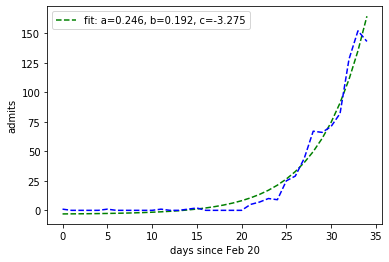

In [369]:
plt.plot(x, func(x, *popt), 'g--',
         label='fit: a={:5.3f}, b={:5.3f}, c={:5.3f}'.format(*popt))
plt.plot(x, y, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

## Use CHIME with above params - doubling time approach
Trying doubling time first. Here's input file used.

    --current-hospitalized 658
    --doubling-time 3.61
    --hospitalized-day 7
    --hospitalized-rate 0.025
    --icu-days 9
    --icu-rate 0.0075
    --market_share 0.32
    --infectious-days 14
    --n-days 120
    --relative-contact-rate 0.31
    --population 5026226
    --ventilated-day 10
    --ventilated-rate 0.005

In [370]:
# dt3p61_df = pd.read_csv("using_chime_cli/2020-03-30_projected_admits_dt3.61.csv", 
#                         parse_dates = ['date'],
#                        index_col = 0)

# dt3p61_df = dt3p61_df.replace({np.nan: None})

# Barf out a dictionary so I can create hard coded data version
# dt3p61_df.to_dict()

Here's the results as a dictionary.

In [371]:
admits_df_dt_dict = {'day': {0: -34,
  1: -33,
  2: -32,
  3: -31,
  4: -30,
  5: -29,
  6: -28,
  7: -27,
  8: -26,
  9: -25,
  10: -24,
  11: -23,
  12: -22,
  13: -21,
  14: -20,
  15: -19,
  16: -18,
  17: -17,
  18: -16,
  19: -15,
  20: -14,
  21: -13,
  22: -12,
  23: -11,
  24: -10,
  25: -9,
  26: -8,
  27: -7,
  28: -6,
  29: -5,
  30: -4,
  31: -3,
  32: -2,
  33: -1,
  34: 0,
  35: 1,
  36: 2,
  37: 3,
  38: 4,
  39: 5,
  40: 6,
  41: 7,
  42: 8,
  43: 9,
  44: 10,
  45: 11,
  46: 12,
  47: 13,
  48: 14,
  49: 15,
  50: 16,
  51: 17,
  52: 18,
  53: 19,
  54: 20,
  55: 21,
  56: 22,
  57: 23,
  58: 24,
  59: 25,
  60: 26,
  61: 27,
  62: 28,
  63: 29,
  64: 30,
  65: 31,
  66: 32,
  67: 33,
  68: 34,
  69: 35,
  70: 36,
  71: 37,
  72: 38,
  73: 39,
  74: 40,
  75: 41,
  76: 42,
  77: 43,
  78: 44,
  79: 45,
  80: 46,
  81: 47,
  82: 48,
  83: 49,
  84: 50,
  85: 51,
  86: 52,
  87: 53,
  88: 54,
  89: 55,
  90: 56,
  91: 57,
  92: 58,
  93: 59,
  94: 60,
  95: 61,
  96: 62,
  97: 63,
  98: 64,
  99: 65,
  100: 66,
  101: 67,
  102: 68,
  103: 69,
  104: 70,
  105: 71,
  106: 72,
  107: 73,
  108: 74,
  109: 75,
  110: 76,
  111: 77,
  112: 78,
  113: 79,
  114: 80,
  115: 81,
  116: 82,
  117: 83,
  118: 84,
  119: 85,
  120: 86,
  121: 87,
  122: 88,
  123: 89,
  124: 90,
  125: 91,
  126: 92,
  127: 93,
  128: 94,
  129: 95,
  130: 96,
  131: 97,
  132: 98,
  133: 99,
  134: 100,
  135: 101,
  136: 102,
  137: 103,
  138: 104,
  139: 105,
  140: 106,
  141: 107,
  142: 108,
  143: 109,
  144: 110,
  145: 111,
  146: 112,
  147: 113,
  148: 114,
  149: 115,
  150: 116,
  151: 117,
  152: 118,
  153: 119,
  154: 120},
 'date': {0: Timestamp('2020-02-25 00:00:00'),
  1: Timestamp('2020-02-26 00:00:00'),
  2: Timestamp('2020-02-27 00:00:00'),
  3: Timestamp('2020-02-28 00:00:00'),
  4: Timestamp('2020-02-29 00:00:00'),
  5: Timestamp('2020-03-01 00:00:00'),
  6: Timestamp('2020-03-02 00:00:00'),
  7: Timestamp('2020-03-03 00:00:00'),
  8: Timestamp('2020-03-04 00:00:00'),
  9: Timestamp('2020-03-05 00:00:00'),
  10: Timestamp('2020-03-06 00:00:00'),
  11: Timestamp('2020-03-07 00:00:00'),
  12: Timestamp('2020-03-08 00:00:00'),
  13: Timestamp('2020-03-09 00:00:00'),
  14: Timestamp('2020-03-10 00:00:00'),
  15: Timestamp('2020-03-11 00:00:00'),
  16: Timestamp('2020-03-12 00:00:00'),
  17: Timestamp('2020-03-13 00:00:00'),
  18: Timestamp('2020-03-14 00:00:00'),
  19: Timestamp('2020-03-15 00:00:00'),
  20: Timestamp('2020-03-16 00:00:00'),
  21: Timestamp('2020-03-17 00:00:00'),
  22: Timestamp('2020-03-18 00:00:00'),
  23: Timestamp('2020-03-19 00:00:00'),
  24: Timestamp('2020-03-20 00:00:00'),
  25: Timestamp('2020-03-21 00:00:00'),
  26: Timestamp('2020-03-22 00:00:00'),
  27: Timestamp('2020-03-23 00:00:00'),
  28: Timestamp('2020-03-24 00:00:00'),
  29: Timestamp('2020-03-25 00:00:00'),
  30: Timestamp('2020-03-26 00:00:00'),
  31: Timestamp('2020-03-27 00:00:00'),
  32: Timestamp('2020-03-28 00:00:00'),
  33: Timestamp('2020-03-29 00:00:00'),
  34: Timestamp('2020-03-30 00:00:00'),
  35: Timestamp('2020-03-31 00:00:00'),
  36: Timestamp('2020-04-01 00:00:00'),
  37: Timestamp('2020-04-02 00:00:00'),
  38: Timestamp('2020-04-03 00:00:00'),
  39: Timestamp('2020-04-04 00:00:00'),
  40: Timestamp('2020-04-05 00:00:00'),
  41: Timestamp('2020-04-06 00:00:00'),
  42: Timestamp('2020-04-07 00:00:00'),
  43: Timestamp('2020-04-08 00:00:00'),
  44: Timestamp('2020-04-09 00:00:00'),
  45: Timestamp('2020-04-10 00:00:00'),
  46: Timestamp('2020-04-11 00:00:00'),
  47: Timestamp('2020-04-12 00:00:00'),
  48: Timestamp('2020-04-13 00:00:00'),
  49: Timestamp('2020-04-14 00:00:00'),
  50: Timestamp('2020-04-15 00:00:00'),
  51: Timestamp('2020-04-16 00:00:00'),
  52: Timestamp('2020-04-17 00:00:00'),
  53: Timestamp('2020-04-18 00:00:00'),
  54: Timestamp('2020-04-19 00:00:00'),
  55: Timestamp('2020-04-20 00:00:00'),
  56: Timestamp('2020-04-21 00:00:00'),
  57: Timestamp('2020-04-22 00:00:00'),
  58: Timestamp('2020-04-23 00:00:00'),
  59: Timestamp('2020-04-24 00:00:00'),
  60: Timestamp('2020-04-25 00:00:00'),
  61: Timestamp('2020-04-26 00:00:00'),
  62: Timestamp('2020-04-27 00:00:00'),
  63: Timestamp('2020-04-28 00:00:00'),
  64: Timestamp('2020-04-29 00:00:00'),
  65: Timestamp('2020-04-30 00:00:00'),
  66: Timestamp('2020-05-01 00:00:00'),
  67: Timestamp('2020-05-02 00:00:00'),
  68: Timestamp('2020-05-03 00:00:00'),
  69: Timestamp('2020-05-04 00:00:00'),
  70: Timestamp('2020-05-05 00:00:00'),
  71: Timestamp('2020-05-06 00:00:00'),
  72: Timestamp('2020-05-07 00:00:00'),
  73: Timestamp('2020-05-08 00:00:00'),
  74: Timestamp('2020-05-09 00:00:00'),
  75: Timestamp('2020-05-10 00:00:00'),
  76: Timestamp('2020-05-11 00:00:00'),
  77: Timestamp('2020-05-12 00:00:00'),
  78: Timestamp('2020-05-13 00:00:00'),
  79: Timestamp('2020-05-14 00:00:00'),
  80: Timestamp('2020-05-15 00:00:00'),
  81: Timestamp('2020-05-16 00:00:00'),
  82: Timestamp('2020-05-17 00:00:00'),
  83: Timestamp('2020-05-18 00:00:00'),
  84: Timestamp('2020-05-19 00:00:00'),
  85: Timestamp('2020-05-20 00:00:00'),
  86: Timestamp('2020-05-21 00:00:00'),
  87: Timestamp('2020-05-22 00:00:00'),
  88: Timestamp('2020-05-23 00:00:00'),
  89: Timestamp('2020-05-24 00:00:00'),
  90: Timestamp('2020-05-25 00:00:00'),
  91: Timestamp('2020-05-26 00:00:00'),
  92: Timestamp('2020-05-27 00:00:00'),
  93: Timestamp('2020-05-28 00:00:00'),
  94: Timestamp('2020-05-29 00:00:00'),
  95: Timestamp('2020-05-30 00:00:00'),
  96: Timestamp('2020-05-31 00:00:00'),
  97: Timestamp('2020-06-01 00:00:00'),
  98: Timestamp('2020-06-02 00:00:00'),
  99: Timestamp('2020-06-03 00:00:00'),
  100: Timestamp('2020-06-04 00:00:00'),
  101: Timestamp('2020-06-05 00:00:00'),
  102: Timestamp('2020-06-06 00:00:00'),
  103: Timestamp('2020-06-07 00:00:00'),
  104: Timestamp('2020-06-08 00:00:00'),
  105: Timestamp('2020-06-09 00:00:00'),
  106: Timestamp('2020-06-10 00:00:00'),
  107: Timestamp('2020-06-11 00:00:00'),
  108: Timestamp('2020-06-12 00:00:00'),
  109: Timestamp('2020-06-13 00:00:00'),
  110: Timestamp('2020-06-14 00:00:00'),
  111: Timestamp('2020-06-15 00:00:00'),
  112: Timestamp('2020-06-16 00:00:00'),
  113: Timestamp('2020-06-17 00:00:00'),
  114: Timestamp('2020-06-18 00:00:00'),
  115: Timestamp('2020-06-19 00:00:00'),
  116: Timestamp('2020-06-20 00:00:00'),
  117: Timestamp('2020-06-21 00:00:00'),
  118: Timestamp('2020-06-22 00:00:00'),
  119: Timestamp('2020-06-23 00:00:00'),
  120: Timestamp('2020-06-24 00:00:00'),
  121: Timestamp('2020-06-25 00:00:00'),
  122: Timestamp('2020-06-26 00:00:00'),
  123: Timestamp('2020-06-27 00:00:00'),
  124: Timestamp('2020-06-28 00:00:00'),
  125: Timestamp('2020-06-29 00:00:00'),
  126: Timestamp('2020-06-30 00:00:00'),
  127: Timestamp('2020-07-01 00:00:00'),
  128: Timestamp('2020-07-02 00:00:00'),
  129: Timestamp('2020-07-03 00:00:00'),
  130: Timestamp('2020-07-04 00:00:00'),
  131: Timestamp('2020-07-05 00:00:00'),
  132: Timestamp('2020-07-06 00:00:00'),
  133: Timestamp('2020-07-07 00:00:00'),
  134: Timestamp('2020-07-08 00:00:00'),
  135: Timestamp('2020-07-09 00:00:00'),
  136: Timestamp('2020-07-10 00:00:00'),
  137: Timestamp('2020-07-11 00:00:00'),
  138: Timestamp('2020-07-12 00:00:00'),
  139: Timestamp('2020-07-13 00:00:00'),
  140: Timestamp('2020-07-14 00:00:00'),
  141: Timestamp('2020-07-15 00:00:00'),
  142: Timestamp('2020-07-16 00:00:00'),
  143: Timestamp('2020-07-17 00:00:00'),
  144: Timestamp('2020-07-18 00:00:00'),
  145: Timestamp('2020-07-19 00:00:00'),
  146: Timestamp('2020-07-20 00:00:00'),
  147: Timestamp('2020-07-21 00:00:00'),
  148: Timestamp('2020-07-22 00:00:00'),
  149: Timestamp('2020-07-23 00:00:00'),
  150: Timestamp('2020-07-24 00:00:00'),
  151: Timestamp('2020-07-25 00:00:00'),
  152: Timestamp('2020-07-26 00:00:00'),
  153: Timestamp('2020-07-27 00:00:00'),
  154: Timestamp('2020-07-28 00:00:00')},
 'hospitalized': {0: None,
  1: 0.28310821138712994,
  2: 0.3430340403402965,
  3: 0.41564313266782427,
  4: 0.5036192828166834,
  5: 0.6102138938691066,
  6: 0.7393658901014439,
  7: 0.8958468995540741,
  8: 1.085437002594766,
  9: 1.3151374385949,
  10: 1.5934279793565027,
  11: 1.9305782560452016,
  12: 2.3390242135148918,
  13: 2.8338231158105103,
  14: 3.43320319903985,
  15: 4.1592272272046715,
  16: 5.038592919617905,
  17: 6.103597549204952,
  18: 7.393299012493187,
  19: 8.954911373580837,
  20: 10.845479270080574,
  21: 13.133882546212703,
  22: 15.903229828765962,
  23: 19.25370707026245,
  24: 23.30595363282464,
  25: 28.205043104884034,
  26: 34.125146891872674,
  27: 41.274952895726756,
  28: 49.903895118044005,
  29: 60.3092167003449,
  30: 72.8438300739748,
  31: 87.92484145003954,
  32: 106.04245647560066,
  33: 127.76875812204004,
  34: 153.76552008345325,
  35: 127.5049331581938,
  36: 142.2877266121809,
  37: 158.63482615737303,
  38: 176.67412495195842,
  39: 196.53430931726325,
  40: 218.34193474172184,
  41: 242.21768814864552,
  42: 268.2717294677164,
  43: 296.5980214432375,
  44: 327.26758740164365,
  45: 360.3206868042234,
  46: 395.75797223429663,
  47: 433.53079268911233,
  48: 473.5309385458658,
  49: 515.5802819927629,
  50: 559.4209467298679,
  51: 604.706829223006,
  52: 650.9974693056074,
  53: 697.7554001685166,
  54: 744.3481587643518,
  55: 790.0560654465609,
  56: 834.0866472890848,
  57: 875.596156957934,
  58: 913.7180270085083,
  59: 947.597332840558,
  60: 976.4294937028408,
  61: 999.500638078216,
  62: 1016.2264418250197,
  63: 1026.185958778653,
  64: 1029.1471134764506,
  65: 1025.0811546081823,
  66: 1014.1644246070756,
  67: 996.7671419985454,
  68: 973.4303074816527,
  69: 944.833098791274,
  70: 911.7540113491086,
  71: 875.0294070747515,
  72: 835.5130292054711,
  73: 794.0395005323662,
  74: 751.3939893489078,
  75: 708.2892732897271,
  76: 665.3505158595982,
  77: 623.1073125607436,
  78: 581.9920279282705,
  79: 542.3431445542957,
  80: 504.4122541061988,
  81: 468.3733894451106,
  82: 434.3335700139796,
  83: 402.3436577267457,
  84: 372.40885649037233,
  85: 344.4984070666796,
  86: 318.5542142402992,
  87: 294.49828891607467,
  88: 272.23899428868026,
  89: 251.67615708483936,
  90: 232.70514840330728,
  91: 215.2200605620237,
  92: 199.1161127547384,
  93: 184.29141439253726,
  94: 170.64820481264178,
  95: 158.09367458071208,
  96: 146.540458982563,
  97: 135.90687986843113,
  98: 126.11699859854707,
  99: 117.10053087197592,
  100: 108.79266386944073,
  101: 101.13380739517015,
  102: 94.06930345974979,
  103: 87.54911284379341,
  104: 81.5274924441037,
  105: 75.96267345022352,
  106: 70.8165474620546,
  107: 66.05436539195944,
  108: 61.64445226452518,
  109: 57.55793972794345,
  110: 53.76851712935604,
  111: 50.2522013102207,
  112: 46.987124783809115,
  113: 43.953341621730935,
  114: 41.13265015619254,
  115: 38.50843147424894,
  116: 36.06550261535449,
  117: 33.78998336255609,
  118: 31.669175533330414,
  119: 29.69145371140621,
  120: 27.846166413051833,
  121: 26.123546741007885,
  122: 24.51463164472807,
  123: 23.011188971926455,
  124: 21.605651562691488,
  125: 20.291057701106183,
  126: 19.06099730089773,
  127: 17.909563258494014,
  128: 16.831307460532116,
  129: 15.821200982427401,
  130: 14.87459805973049,
  131: 13.98720345561742,
  132: 13.15504288567172,
  133: 12.374436195139424,
  134: 11.641973015059191,
  135: 10.954490651281958,
  136: 10.309053985918581,
  137: 9.702937193142132,
  138: 9.133607091607699,
  139: 8.598707974124409,
  140: 8.096047771403391,
  141: 7.6235854215410646,
  142: 7.179419329724624,
  143: 6.761776814848418,
  144: 6.36900444953062,
  145: 5.999559210518783,
  146: 5.652000363472324,
  147: 5.324982015183196,
  148: 5.017246271629119,
  149: 4.7276169473771015,
  150: 4.454993776700576,
  151: 4.1983470817431225,
  152: 3.956712857354432,
  153: 3.729188236451592,
  154: None},
 'icu': {0: None,
  1: 0.08493246341613891,
  2: 0.1029102121020889,
  3: 0.12469293980034735,
  4: 0.151085784845005,
  5: 0.1830641681607319,
  6: 0.2218097670304333,
  7: 0.2687540698662221,
  8: 0.32563110077843005,
  9: 0.3945412315784696,
  10: 0.4780283938069512,
  11: 0.579173476813561,
  12: 0.7017072640544666,
  13: 0.8501469347431523,
  14: 1.0299609597119552,
  15: 1.2477681681614021,
  16: 1.511577875885373,
  17: 1.8310792647614849,
  18: 2.217989703747957,
  19: 2.6864734120742457,
  20: 3.253643781024172,
  21: 3.9401647638638164,
  22: 4.770968948629786,
  23: 5.776112121078732,
  24: 6.9917860898473885,
  25: 8.461512931465208,
  26: 10.237544067561815,
  27: 12.382485868718016,
  28: 14.971168535413186,
  29: 18.092765010103488,
  30: 21.853149022192426,
  31: 26.37745243501187,
  32: 31.81273694268017,
  33: 38.330627436612026,
  34: 46.12965602503599,
  35: 38.25147994745811,
  36: 42.68631798365431,
  37: 47.59044784721193,
  38: 53.00223748558756,
  39: 58.96029279517887,
  40: 65.50258042251653,
  41: 72.66530644459374,
  42: 80.48151884031495,
  43: 88.97940643297113,
  44: 98.18027622049307,
  45: 108.096206041267,
  46: 118.72739167028921,
  47: 130.05923780673356,
  48: 142.0592815637599,
  49: 154.6740845978288,
  50: 167.82628401896022,
  51: 181.41204876690173,
  52: 195.29924079168225,
  53: 209.32662005055454,
  54: 223.3044476293057,
  55: 237.0168196339687,
  56: 250.22599418672507,
  57: 262.6788470873803,
  58: 274.115408102552,
  59: 284.2791998521675,
  60: 292.92884811085287,
  61: 299.85019142346385,
  62: 304.8679325475068,
  63: 307.85578763359626,
  64: 308.74413404293585,
  65: 307.5243463824527,
  66: 304.24932738212283,
  67: 299.03014259956404,
  68: 292.02909224449564,
  69: 283.4499296373815,
  70: 273.5262034047337,
  71: 262.50882212242414,
  72: 250.653908761642,
  73: 238.2118501597097,
  74: 225.4181968046724,
  75: 212.4867819869187,
  76: 199.60515475787903,
  77: 186.9321937682234,
  78: 174.5976083784808,
  79: 162.7029433662883,
  80: 151.32367623185928,
  81: 140.5120168335343,
  82: 130.30007100419243,
  83: 120.70309731802445,
  84: 111.72265694711132,
  85: 103.34952212000462,
  86: 95.56626427208904,
  87: 88.3494866748224,
  88: 81.67169828660553,
  89: 75.50284712544997,
  90: 69.81154452099327,
  91: 64.56601816860712,
  92: 59.73483382642189,
  93: 55.287424317761186,
  94: 51.19446144379072,
  95: 47.4281023742151,
  96: 43.9621376947689,
  97: 40.77206396053043,
  98: 37.83509957956449,
  99: 35.13015926159096,
  100: 32.6377991608333,
  101: 30.340142218548866,
  102: 28.220791037927484,
  103: 26.26473385313511,
  104: 24.45824773323329,
  105: 22.78880203506742,
  106: 21.244964238616376,
  107: 19.81630961758856,
  108: 18.493335679357187,
  109: 17.267381918380124,
  110: 16.130555138810447,
  111: 15.075660393065846,
  112: 14.096137435140918,
  113: 13.186002486520009,
  114: 12.339795046858852,
  115: 11.552529442271409,
  116: 10.819650784607804,
  117: 10.136995008764645,
  118: 9.500752660002037,
  119: 8.907436113420774,
  120: 8.353849923916641,
  121: 7.837064022302003,
  122: 7.3543894934191485,
  123: 6.903356691576847,
  124: 6.481695468808539,
  125: 6.087317310331856,
  126: 5.718299190268227,
  127: 5.372868977548933,
  128: 5.049392238159271,
  129: 4.746360294726402,
  130: 4.4623794179206016,
  131: 4.1961610366852256,
  132: 3.946512865701152,
  133: 3.712330858541464,
  134: 3.4925919045181217,
  135: 3.2863471953860426,
  136: 3.0927161957733915,
  137: 2.9108811579462786,
  138: 2.7400821274804907,
  139: 2.579612392237322,
  140: 2.428814331418834,
  141: 2.287075626463775,
  142: 2.153825798917751,
  143: 2.02853304445307,
  144: 1.9107013348602775,
  145: 1.7998677631530882,
  146: 1.6956001090438804,
  147: 1.5974946045553224,
  148: 1.5051738814872806,
  149: 1.418285084213494,
  150: 1.3364981330105363,
  151: 1.2595041245222092,
  152: 1.1870138572066935,
  153: 1.118756470936205,
  154: None},
 'ventilated': {0: None,
  1: 0.056621642277425936,
  2: 0.0686068080680593,
  3: 0.0831286265335649,
  4: 0.10072385656333666,
  5: 0.1220427787738213,
  6: 0.14787317802028874,
  7: 0.17916937991081486,
  8: 0.21708740051895334,
  9: 0.26302748771898,
  10: 0.3186855958713004,
  11: 0.3861156512090407,
  12: 0.4678048427029777,
  13: 0.5667646231621024,
  14: 0.6866406398079699,
  15: 0.8318454454409343,
  16: 1.0077185839235812,
  17: 1.2207195098409906,
  18: 1.4786598024986377,
  19: 1.790982274716166,
  20: 2.1690958540161134,
  21: 2.626776509242543,
  22: 3.180645965753192,
  23: 3.8507414140524863,
  24: 4.661190726564929,
  25: 5.641008620976808,
  26: 6.825029378374537,
  27: 8.25499057914535,
  28: 9.98077902360879,
  29: 12.061843340068993,
  30: 14.56876601479496,
  31: 17.584968290007893,
  32: 21.20849129512013,
  33: 25.55375162440801,
  34: 30.753104016690656,
  35: 25.500986631638735,
  36: 28.457545322436204,
  37: 31.726965231474647,
  38: 35.334824990391674,
  39: 39.30686186345264,
  40: 43.668386948344335,
  41: 48.44353762972912,
  42: 53.65434589354335,
  43: 59.31960428864738,
  44: 65.45351748032886,
  45: 72.0641373608446,
  46: 79.15159444685924,
  47: 86.70615853782247,
  48: 94.70618770917316,
  49: 103.1160563985527,
  50: 111.88418934597372,
  51: 120.9413658446008,
  52: 130.1994938611217,
  53: 139.5510800337031,
  54: 148.86963175287042,
  55: 158.0112130893126,
  56: 166.8173294578166,
  57: 175.11923139158714,
  58: 182.7436054017012,
  59: 189.51946656811148,
  60: 195.285898740568,
  61: 199.90012761564319,
  62: 203.24528836500443,
  63: 205.23719175573117,
  64: 205.8294226952903,
  65: 205.0162309216353,
  66: 202.83288492141537,
  67: 199.35342839970872,
  68: 194.6860614963307,
  69: 188.96661975825464,
  70: 182.35080226982242,
  71: 175.00588141494973,
  72: 167.10260584109437,
  73: 158.80790010647345,
  74: 150.27879786978158,
  75: 141.65785465794488,
  76: 133.07010317191998,
  77: 124.62146251214836,
  78: 116.39840558565449,
  79: 108.4686289108595,
  80: 100.88245082124013,
  81: 93.67467788902195,
  82: 86.86671400279556,
  83: 80.46873154534933,
  84: 74.481771298073,
  85: 68.89968141333702,
  86: 63.71084284806057,
  87: 58.899657783214934,
  88: 54.44779885773551,
  89: 50.33523141696696,
  90: 46.541029680662184,
  91: 43.04401211240384,
  92: 39.82322255094823,
  93: 36.858282878508355,
  94: 34.129640962526544,
  95: 31.61873491614369,
  96: 29.30809179651351,
  97: 27.181375973686954,
  98: 25.22339971970814,
  99: 23.420106174394284,
  100: 21.758532773888874,
  101: 20.226761479032575,
  102: 18.81386069195105,
  103: 17.509822568758864,
  104: 16.305498488821286,
  105: 15.192534690044338,
  106: 14.16330949241001,
  107: 13.21087307839298,
  108: 12.328890452905398,
  109: 11.511587945587053,
  110: 10.753703425873027,
  111: 10.050440262043594,
  112: 9.397424956761824,
  113: 8.790668324345459,
  114: 8.226530031238326,
  115: 7.7016862948494245,
  116: 7.213100523071263,
  117: 6.757996672511581,
  118: 6.3338351066659015,
  119: 5.938290742281424,
  120: 5.569233282610186,
  121: 5.2247093482028495,
  122: 4.902926328944887,
  123: 4.602237794386383,
  124: 4.321130312537207,
  125: 4.058211540220327,
  126: 3.812199460180637,
  127: 3.581912651698076,
  128: 3.3662614921058776,
  129: 3.1642401964854803,
  130: 2.9749196119473713,
  131: 2.797440691123484,
  132: 2.631008577133798,
  133: 2.4748872390282486,
  134: 2.3283946030105653,
  135: 2.190898130257665,
  136: 2.0618107971831705,
  137: 1.9405874386302455,
  138: 1.8267214183206304,
  139: 1.7197415948239725,
  140: 1.6192095542801326,
  141: 1.5247170843085769,
  142: 1.4358838659454705,
  143: 1.3523553629693197,
  144: 1.2738008899059423,
  145: 1.1999118421035746,
  146: 1.1304000726950107,
  147: 1.0649964030362753,
  148: 1.0034492543263696,
  149: 0.9455233894741468,
  150: 0.8909987553406609,
  151: 0.8396694163484426,
  152: 0.7913425714714322,
  153: 0.7458376472905002,
  154: None}}

In [372]:
dt3p61_df = pd.DataFrame(admits_df_dt_dict)

In [373]:
dt3p61_df.head()

,day,date,hospitalized,icu,ventilated
0,-34,2020-02-25,NaN,NaN,NaN
1,-33,2020-02-26,0.283108,0.084932,0.056622
2,-32,2020-02-27,0.343034,0.102910,0.068607
3,-31,2020-02-28,0.415643,0.124693,0.083129
4,-30,2020-02-29,0.503619,0.151086,0.100724


Need to shift the index on the CHIME output since it infers a first hospitalized date and that date, while hopefully close, is not guaranteed to match our actual date.

In [374]:
num_days_to_shift = (dt3p61_df.date[0] - actual_df.date[0]).days
print('Shifting CHIME output index by {} days'.format(num_days_to_shift))
dt3p61_df.index = dt3p61_df.index + num_days_to_shift #.shift() only works for DateTime like index
dt3p61_df.head(10)

Shifting CHIME output index by 5 days


,day,date,hospitalized,icu,ventilated
5,-34,2020-02-25,NaN,NaN,NaN
6,-33,2020-02-26,0.283108,0.084932,0.056622
7,-32,2020-02-27,0.343034,0.102910,0.068607
8,-31,2020-02-28,0.415643,0.124693,0.083129
9,-30,2020-02-29,0.503619,0.151086,0.100724
10,-29,2020-03-01,0.610214,0.183064,0.122043
11,-28,2020-03-02,0.739366,0.221810,0.147873
12,-27,2020-03-03,0.895847,0.268754,0.179169
13,-26,2020-03-04,1.085437,0.325631,0.217087
14,-25,2020-03-05,1.315137,0.394541,0.263027


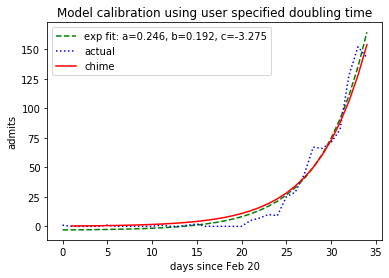

In [375]:
chime_y_dt = np.array(dt3p61_df.hospitalized)[:len(x)]
plt.plot(x, func(x, *popt), 'g--',
         label='exp fit: a={:5.3f}, b={:5.3f}, c={:5.3f}'.format(*popt))
plt.plot(x, y, 'b:', label = 'actual')
plt.plot(x, chime_y_dt, 'r-', label = 'chime')
plt.title('Model calibration using user specified doubling time')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.savefig("model_calibration_dt3p61.png")
plt.show()


### Nice!

## Use CHIME with above params - actual first admit date approach

Now let's see how things look if we use our actual first admit date. Here's input file used.

    --current-hospitalized 658
    --date-first-hospitalized 2020-02-20
    --hospitalized-day 7
    --hospitalized-rate 0.025
    --icu-days 9
    --icu-rate 0.0075
    --market_share 0.32
    --infectious-days 14
    --n-days 120
    --relative-contact-rate 0.31
    --population 5026226
    --ventilated-day 10
    --ventilated-rate 0.005

In [376]:
# fd20200220_df = pd.read_csv("using_chime_cli/2020-03-30_projected_admits_fd20200220.csv", 
#                         parse_dates = ['date'],
#                        index_col = 0)

# fd20200220_df = fd20200220_df.replace({np.nan: None})

# # Barf out a dictionary so I can create hard coded data version
# fd20200220_df.to_dict()

In [377]:
admits_df_fd_dict = {'day': {0: -39,
  1: -38,
  2: -37,
  3: -36,
  4: -35,
  5: -34,
  6: -33,
  7: -32,
  8: -31,
  9: -30,
  10: -29,
  11: -28,
  12: -27,
  13: -26,
  14: -25,
  15: -24,
  16: -23,
  17: -22,
  18: -21,
  19: -20,
  20: -19,
  21: -18,
  22: -17,
  23: -16,
  24: -15,
  25: -14,
  26: -13,
  27: -12,
  28: -11,
  29: -10,
  30: -9,
  31: -8,
  32: -7,
  33: -6,
  34: -5,
  35: -4,
  36: -3,
  37: -2,
  38: -1,
  39: 0,
  40: 1,
  41: 2,
  42: 3,
  43: 4,
  44: 5,
  45: 6,
  46: 7,
  47: 8,
  48: 9,
  49: 10,
  50: 11,
  51: 12,
  52: 13,
  53: 14,
  54: 15,
  55: 16,
  56: 17,
  57: 18,
  58: 19,
  59: 20,
  60: 21,
  61: 22,
  62: 23,
  63: 24,
  64: 25,
  65: 26,
  66: 27,
  67: 28,
  68: 29,
  69: 30,
  70: 31,
  71: 32,
  72: 33,
  73: 34,
  74: 35,
  75: 36,
  76: 37,
  77: 38,
  78: 39,
  79: 40,
  80: 41,
  81: 42,
  82: 43,
  83: 44,
  84: 45,
  85: 46,
  86: 47,
  87: 48,
  88: 49,
  89: 50,
  90: 51,
  91: 52,
  92: 53,
  93: 54,
  94: 55,
  95: 56,
  96: 57,
  97: 58,
  98: 59,
  99: 60,
  100: 61,
  101: 62,
  102: 63,
  103: 64,
  104: 65,
  105: 66,
  106: 67,
  107: 68,
  108: 69,
  109: 70,
  110: 71,
  111: 72,
  112: 73,
  113: 74,
  114: 75,
  115: 76,
  116: 77,
  117: 78,
  118: 79,
  119: 80,
  120: 81,
  121: 82,
  122: 83,
  123: 84,
  124: 85,
  125: 86,
  126: 87,
  127: 88,
  128: 89,
  129: 90,
  130: 91,
  131: 92,
  132: 93,
  133: 94,
  134: 95,
  135: 96,
  136: 97,
  137: 98,
  138: 99,
  139: 100,
  140: 101,
  141: 102,
  142: 103,
  143: 104,
  144: 105,
  145: 106,
  146: 107,
  147: 108,
  148: 109,
  149: 110,
  150: 111,
  151: 112,
  152: 113,
  153: 114,
  154: 115,
  155: 116,
  156: 117,
  157: 118,
  158: 119,
  159: 120},
 'date': {0: Timestamp('2020-02-20 00:00:00'),
  1: Timestamp('2020-02-21 00:00:00'),
  2: Timestamp('2020-02-22 00:00:00'),
  3: Timestamp('2020-02-23 00:00:00'),
  4: Timestamp('2020-02-24 00:00:00'),
  5: Timestamp('2020-02-25 00:00:00'),
  6: Timestamp('2020-02-26 00:00:00'),
  7: Timestamp('2020-02-27 00:00:00'),
  8: Timestamp('2020-02-28 00:00:00'),
  9: Timestamp('2020-02-29 00:00:00'),
  10: Timestamp('2020-03-01 00:00:00'),
  11: Timestamp('2020-03-02 00:00:00'),
  12: Timestamp('2020-03-03 00:00:00'),
  13: Timestamp('2020-03-04 00:00:00'),
  14: Timestamp('2020-03-05 00:00:00'),
  15: Timestamp('2020-03-06 00:00:00'),
  16: Timestamp('2020-03-07 00:00:00'),
  17: Timestamp('2020-03-08 00:00:00'),
  18: Timestamp('2020-03-09 00:00:00'),
  19: Timestamp('2020-03-10 00:00:00'),
  20: Timestamp('2020-03-11 00:00:00'),
  21: Timestamp('2020-03-12 00:00:00'),
  22: Timestamp('2020-03-13 00:00:00'),
  23: Timestamp('2020-03-14 00:00:00'),
  24: Timestamp('2020-03-15 00:00:00'),
  25: Timestamp('2020-03-16 00:00:00'),
  26: Timestamp('2020-03-17 00:00:00'),
  27: Timestamp('2020-03-18 00:00:00'),
  28: Timestamp('2020-03-19 00:00:00'),
  29: Timestamp('2020-03-20 00:00:00'),
  30: Timestamp('2020-03-21 00:00:00'),
  31: Timestamp('2020-03-22 00:00:00'),
  32: Timestamp('2020-03-23 00:00:00'),
  33: Timestamp('2020-03-24 00:00:00'),
  34: Timestamp('2020-03-25 00:00:00'),
  35: Timestamp('2020-03-26 00:00:00'),
  36: Timestamp('2020-03-27 00:00:00'),
  37: Timestamp('2020-03-28 00:00:00'),
  38: Timestamp('2020-03-29 00:00:00'),
  39: Timestamp('2020-03-30 00:00:00'),
  40: Timestamp('2020-03-31 00:00:00'),
  41: Timestamp('2020-04-01 00:00:00'),
  42: Timestamp('2020-04-02 00:00:00'),
  43: Timestamp('2020-04-03 00:00:00'),
  44: Timestamp('2020-04-04 00:00:00'),
  45: Timestamp('2020-04-05 00:00:00'),
  46: Timestamp('2020-04-06 00:00:00'),
  47: Timestamp('2020-04-07 00:00:00'),
  48: Timestamp('2020-04-08 00:00:00'),
  49: Timestamp('2020-04-09 00:00:00'),
  50: Timestamp('2020-04-10 00:00:00'),
  51: Timestamp('2020-04-11 00:00:00'),
  52: Timestamp('2020-04-12 00:00:00'),
  53: Timestamp('2020-04-13 00:00:00'),
  54: Timestamp('2020-04-14 00:00:00'),
  55: Timestamp('2020-04-15 00:00:00'),
  56: Timestamp('2020-04-16 00:00:00'),
  57: Timestamp('2020-04-17 00:00:00'),
  58: Timestamp('2020-04-18 00:00:00'),
  59: Timestamp('2020-04-19 00:00:00'),
  60: Timestamp('2020-04-20 00:00:00'),
  61: Timestamp('2020-04-21 00:00:00'),
  62: Timestamp('2020-04-22 00:00:00'),
  63: Timestamp('2020-04-23 00:00:00'),
  64: Timestamp('2020-04-24 00:00:00'),
  65: Timestamp('2020-04-25 00:00:00'),
  66: Timestamp('2020-04-26 00:00:00'),
  67: Timestamp('2020-04-27 00:00:00'),
  68: Timestamp('2020-04-28 00:00:00'),
  69: Timestamp('2020-04-29 00:00:00'),
  70: Timestamp('2020-04-30 00:00:00'),
  71: Timestamp('2020-05-01 00:00:00'),
  72: Timestamp('2020-05-02 00:00:00'),
  73: Timestamp('2020-05-03 00:00:00'),
  74: Timestamp('2020-05-04 00:00:00'),
  75: Timestamp('2020-05-05 00:00:00'),
  76: Timestamp('2020-05-06 00:00:00'),
  77: Timestamp('2020-05-07 00:00:00'),
  78: Timestamp('2020-05-08 00:00:00'),
  79: Timestamp('2020-05-09 00:00:00'),
  80: Timestamp('2020-05-10 00:00:00'),
  81: Timestamp('2020-05-11 00:00:00'),
  82: Timestamp('2020-05-12 00:00:00'),
  83: Timestamp('2020-05-13 00:00:00'),
  84: Timestamp('2020-05-14 00:00:00'),
  85: Timestamp('2020-05-15 00:00:00'),
  86: Timestamp('2020-05-16 00:00:00'),
  87: Timestamp('2020-05-17 00:00:00'),
  88: Timestamp('2020-05-18 00:00:00'),
  89: Timestamp('2020-05-19 00:00:00'),
  90: Timestamp('2020-05-20 00:00:00'),
  91: Timestamp('2020-05-21 00:00:00'),
  92: Timestamp('2020-05-22 00:00:00'),
  93: Timestamp('2020-05-23 00:00:00'),
  94: Timestamp('2020-05-24 00:00:00'),
  95: Timestamp('2020-05-25 00:00:00'),
  96: Timestamp('2020-05-26 00:00:00'),
  97: Timestamp('2020-05-27 00:00:00'),
  98: Timestamp('2020-05-28 00:00:00'),
  99: Timestamp('2020-05-29 00:00:00'),
  100: Timestamp('2020-05-30 00:00:00'),
  101: Timestamp('2020-05-31 00:00:00'),
  102: Timestamp('2020-06-01 00:00:00'),
  103: Timestamp('2020-06-02 00:00:00'),
  104: Timestamp('2020-06-03 00:00:00'),
  105: Timestamp('2020-06-04 00:00:00'),
  106: Timestamp('2020-06-05 00:00:00'),
  107: Timestamp('2020-06-06 00:00:00'),
  108: Timestamp('2020-06-07 00:00:00'),
  109: Timestamp('2020-06-08 00:00:00'),
  110: Timestamp('2020-06-09 00:00:00'),
  111: Timestamp('2020-06-10 00:00:00'),
  112: Timestamp('2020-06-11 00:00:00'),
  113: Timestamp('2020-06-12 00:00:00'),
  114: Timestamp('2020-06-13 00:00:00'),
  115: Timestamp('2020-06-14 00:00:00'),
  116: Timestamp('2020-06-15 00:00:00'),
  117: Timestamp('2020-06-16 00:00:00'),
  118: Timestamp('2020-06-17 00:00:00'),
  119: Timestamp('2020-06-18 00:00:00'),
  120: Timestamp('2020-06-19 00:00:00'),
  121: Timestamp('2020-06-20 00:00:00'),
  122: Timestamp('2020-06-21 00:00:00'),
  123: Timestamp('2020-06-22 00:00:00'),
  124: Timestamp('2020-06-23 00:00:00'),
  125: Timestamp('2020-06-24 00:00:00'),
  126: Timestamp('2020-06-25 00:00:00'),
  127: Timestamp('2020-06-26 00:00:00'),
  128: Timestamp('2020-06-27 00:00:00'),
  129: Timestamp('2020-06-28 00:00:00'),
  130: Timestamp('2020-06-29 00:00:00'),
  131: Timestamp('2020-06-30 00:00:00'),
  132: Timestamp('2020-07-01 00:00:00'),
  133: Timestamp('2020-07-02 00:00:00'),
  134: Timestamp('2020-07-03 00:00:00'),
  135: Timestamp('2020-07-04 00:00:00'),
  136: Timestamp('2020-07-05 00:00:00'),
  137: Timestamp('2020-07-06 00:00:00'),
  138: Timestamp('2020-07-07 00:00:00'),
  139: Timestamp('2020-07-08 00:00:00'),
  140: Timestamp('2020-07-09 00:00:00'),
  141: Timestamp('2020-07-10 00:00:00'),
  142: Timestamp('2020-07-11 00:00:00'),
  143: Timestamp('2020-07-12 00:00:00'),
  144: Timestamp('2020-07-13 00:00:00'),
  145: Timestamp('2020-07-14 00:00:00'),
  146: Timestamp('2020-07-15 00:00:00'),
  147: Timestamp('2020-07-16 00:00:00'),
  148: Timestamp('2020-07-17 00:00:00'),
  149: Timestamp('2020-07-18 00:00:00'),
  150: Timestamp('2020-07-19 00:00:00'),
  151: Timestamp('2020-07-20 00:00:00'),
  152: Timestamp('2020-07-21 00:00:00'),
  153: Timestamp('2020-07-22 00:00:00'),
  154: Timestamp('2020-07-23 00:00:00'),
  155: Timestamp('2020-07-24 00:00:00'),
  156: Timestamp('2020-07-25 00:00:00'),
  157: Timestamp('2020-07-26 00:00:00'),
  158: Timestamp('2020-07-27 00:00:00'),
  159: Timestamp('2020-07-28 00:00:00')},
 'hospitalized': {0: None,
  1: 0.26063568643129265,
  2: 0.30994780361612073,
  3: 0.3685887684065661,
  4: 0.4383230045117259,
  5: 0.5212484848145089,
  6: 0.6198597166427717,
  7: 0.7371225920430557,
  8: 0.8765633262449724,
  9: 1.042374119124572,
  10: 1.2395386602445295,
  11: 1.4739811704548382,
  12: 1.752743346298255,
  13: 2.0841943635917453,
  14: 2.478280021331585,
  15: 2.9468181858690787,
  16: 3.503848948669013,
  17: 4.166049359819457,
  18: 4.953224263771183,
  19: 5.8888866603933,
  20: 7.000943153724173,
  21: 8.322502431663082,
  22: 9.892827322227184,
  23: 11.758453746026738,
  24: 13.974502735048445,
  25: 16.606214451970516,
  26: 19.73073556093623,
  27: 23.4391929676366,
  28: 27.839087261695056,
  29: 33.05703727755348,
  30: 39.241901779511544,
  31: 46.568293595526285,
  32: 55.24048311496336,
  33: 65.49665859068324,
  34: 77.6134657096501,
  35: 91.9106826692108,
  36: 108.75579230321215,
  37: 128.56808097881174,
  38: 151.8217152864736,
  39: 179.04701216563217,
  40: 145.471884626862,
  41: 159.89548608342258,
  42: 175.57774145036728,
  43: 192.59146131063633,
  44: 211.00537625107518,
  45: 230.88182970492718,
  46: 252.27405479023946,
  47: 275.22301889684917,
  48: 299.7538372915992,
  49: 325.871781288452,
  50: 353.55793840149266,
  51: 382.7646217812385,
  52: 413.41067385325096,
  53: 445.37686313927225,
  54: 478.50163108998186,
  55: 512.5775030663808,
  56: 547.3485281814219,
  57: 582.5091485306383,
  58: 617.7049099303331,
  59: 652.53540357582,
  60: 686.559761745466,
  61: 719.3049141850042,
  62: 750.2766433517609,
  63: 778.9732615463307,
  64: 804.9014849968097,
  65: 827.5938220979386,
  66: 846.6265558166923,
  67: 861.6372185615802,
  68: 872.3403652742453,
  69: 878.5404732462266,
  70: 880.1409473938803,
  71: 877.148481220298,
  72: 869.6723905561047,
  73: 857.9189566707864,
  74: 842.1812346273109,
  75: 822.8251481088338,
  76: 800.2729584926857,
  77: 774.9853354032492,
  78: 747.4432607351192,
  79: 718.1308808985123,
  80: 687.5202114417625,
  81: 656.0583319680553,
  82: 624.1574266080788,
  83: 592.1877605181289,
  84: 560.4734609846673,
  85: 529.2908068526449,
  86: 498.86862592948825,
  87: 469.3903523203698,
  88: 440.9972945424269,
  89: 413.79269846236997,
  90: 387.8462441458069,
  91: 363.19868157745805,
  92: 339.8663781875548,
  93: 317.8456150332277,
  94: 297.1165245464035,
  95: 277.6466091512229,
  96: 259.393816417185,
  97: 242.30917337058415,
  98: 226.33900132020423,
  99: 211.42674449165497,
  100: 197.51445236410652,
  101: 184.54395820241191,
  102: 172.45779603748818,
  103: 161.19989621212153,
  104: 150.71609632036416,
  105: 140.9545004800166,
  106: 131.86571578634175,
  107: 123.40299077035887,
  108: 115.52227690087601,
  109: 108.18223072100956,
  110: 101.34417114614187,
  111: 94.97200378067646,
  112: 89.03212181977871,
  113: 83.49329116675653,
  114: 78.3265257760213,
  115: 73.50495789424167,
  116: 69.00370677465979,
  117: 64.79974855121691,
  118: 60.871789243719824,
  119: 57.20014229659864,
  120: 53.766611604485654,
  121: 50.554380627931096,
  122: 47.54790793235588,
  123: 44.73282927802211,
  124: 42.09586623506766,
  125: 39.62474118575483,
  126: 37.30809849574871,
  127: 35.135431582348254,
  128: 33.097015572573575,
  129: 31.18384522476117,
  130: 29.387577778747072,
  131: 27.700480400802924,
  132: 26.11538189517887,
  133: 24.625628365924054,
  134: 23.22504252604267,
  135: 21.907886367196628,
  136: 20.668826919878484,
  137: 19.502904852044594,
  138: 18.405505670336424,
  139: 17.372333306724613,
  140: 16.399385888449615,
  141: 15.482933505816616,
  142: 14.619497807085281,
  143: 13.80583326327178,
  144: 13.038909959897866,
  145: 12.315897783417313,
  146: 11.634151882921287,
  147: 10.991199296695411,
  148: 10.384726643984322,
  149: 9.812568790446676,
  150: 9.272698403874527,
  151: 8.763216324688983,
  152: 8.282342681595765,
  153: 7.828408689922072,
  154: 7.399849074812664,
  155: 6.99519506735669,
  156: 6.613067925834912,
  157: 6.252172938868171,
  158: 5.91129387068213,
  159: None},
 'icu': {0: None,
  1: 0.07819070592938776,
  2: 0.09298434108483616,
  3: 0.11057663052196992,
  4: 0.13149690135351766,
  5: 0.1563745454443528,
  6: 0.18595791499283126,
  7: 0.22113677761291692,
  8: 0.2629689978734915,
  9: 0.3127122357373717,
  10: 0.3718615980733588,
  11: 0.4421943511364508,
  12: 0.5258230038894771,
  13: 0.6252583090775232,
  14: 0.7434840063994756,
  15: 0.884045455760722,
  16: 1.0511546846007054,
  17: 1.2498148079458378,
  18: 1.4859672791313532,
  19: 1.7666659981179915,
  20: 2.1002829461172516,
  21: 2.4967507294989235,
  22: 2.9678481966681516,
  23: 3.5275361238080194,
  24: 4.192350820514534,
  25: 4.981864335591156,
  26: 5.919220668280865,
  27: 7.031757890290983,
  28: 8.351726178508521,
  29: 9.917111183266053,
  30: 11.772570533853454,
  31: 13.97048807865788,
  32: 16.572144934489017,
  33: 19.64899757720497,
  34: 23.284039712895023,
  35: 27.57320480076325,
  36: 32.62673769096364,
  37: 38.5704242936435,
  38: 45.546514585942106,
  39: 53.714103649689605,
  40: 43.64156538805866,
  41: 47.968645825026776,
  42: 52.67332243511015,
  43: 57.77743839319089,
  44: 63.301612875322455,
  45: 69.26454891147819,
  46: 75.68221643707182,
  47: 82.56690566905479,
  48: 89.92615118747972,
  49: 97.76153438653569,
  50: 106.06738152044771,
  51: 114.82938653437168,
  52: 124.023202155975,
  53: 133.6130589417817,
  54: 143.5504893269947,
  55: 153.77325091991432,
  56: 164.2045584544262,
  57: 174.75274455919183,
  58: 185.3114729791,
  59: 195.76062107274586,
  60: 205.96792852363976,
  61: 215.7914742555013,
  62: 225.08299300552792,
  63: 233.69197846389991,
  64: 241.47044549904285,
  65: 248.27814662938184,
  66: 253.9879667450073,
  67: 258.4911655684737,
  68: 261.7021095822738,
  69: 263.56214197386726,
  70: 264.04228421816515,
  71: 263.1445443660896,
  72: 260.9017171668311,
  73: 257.37568700123575,
  74: 252.65437038819252,
  75: 246.84754443265047,
  76: 240.08188754780716,
  77: 232.49560062097225,
  78: 224.232978220537,
  79: 215.43926426955383,
  80: 206.25606343252912,
  81: 196.81749959041645,
  82: 187.24722798242328,
  83: 177.65632815543813,
  84: 168.14203829539932,
  85: 158.7872420557942,
  86: 149.6605877788479,
  87: 140.81710569611099,
  88: 132.29918836272736,
  89: 124.13780953870993,
  90: 116.3538732437428,
  91: 108.95960447323704,
  92: 101.9599134562668,
  93: 95.35368450996977,
  94: 89.13495736391815,
  95: 83.29398274536835,
  96: 77.81814492515514,
  97: 72.6927520111767,
  98: 67.90170039605982,
  99: 63.42802334749649,
  100: 59.254335709232684,
  101: 55.36318746072357,
  102: 51.73733881124645,
  103: 48.359968863636816,
  104: 45.214828896107065,
  105: 42.28635014400607,
  106: 39.55971473590398,
  107: 37.020897231106574,
  108: 34.65668307026499,
  109: 32.45466921630032,
  110: 30.403251343843287,
  111: 28.491601134201122,
  112: 26.70963654593652,
  113: 25.047987350026236,
  114: 23.497957732804927,
  115: 22.05148736827323,
  116: 20.701112032398672,
  117: 19.43992456536398,
  118: 18.26153677311595,
  119: 17.160042688978134,
  120: 16.129983481348972,
  121: 15.166314188378234,
  122: 14.2643723797064,
  123: 13.419848783407359,
  124: 12.628759870520296,
  125: 11.887422355726812,
  126: 11.192429548724249,
  127: 10.540629474700836,
  128: 9.929104671775349,
  129: 9.355153567426896,
  130: 8.816273333626668,
  131: 8.310144120239785,
  132: 7.834614568553661,
  133: 7.387688509776126,
  134: 6.967512757813893,
  135: 6.572365910156805,
  136: 6.200648075966456,
  137: 5.850871455611923,
  138: 5.52165170110311,
  139: 5.2116999920144735,
  140: 4.919815766535977,
  141: 4.6448800517464415,
  142: 4.385849342124857,
  143: 4.1417499789804415,
  144: 3.9116729879715417,
  145: 3.694769335023011,
  146: 3.4902455648752952,
  147: 3.2973597890122615,
  148: 3.115417993190931,
  149: 2.943770637135458,
  150: 2.7818095211623586,
  151: 2.6289648974070587,
  152: 2.4847028044769104,
  153: 2.348522606978804,
  154: 2.219954722444527,
  155: 2.098558520205188,
  156: 1.9839203777519288,
  157: 1.875651881660815,
  158: 1.7733881612057305,
  159: None},
 'ventilated': {0: None,
  1: 0.052127137286258514,
  2: 0.06198956072322415,
  3: 0.07371775368131317,
  4: 0.08766460090234518,
  5: 0.10424969696290183,
  6: 0.12397194332855432,
  7: 0.14742451840861126,
  8: 0.17531266524899436,
  9: 0.20847482382491436,
  10: 0.24790773204890604,
  11: 0.2947962340909676,
  12: 0.3505486692596516,
  13: 0.4168388727183485,
  14: 0.495656004266317,
  15: 0.5893636371738151,
  16: 0.700769789733803,
  17: 0.8332098719638923,
  18: 0.9906448527542356,
  19: 1.1777773320786604,
  20: 1.400188630744834,
  21: 1.6645004863326154,
  22: 1.9785654644454385,
  23: 2.3516907492053445,
  24: 2.794900547009691,
  25: 3.3212428903941067,
  26: 3.946147112187244,
  27: 4.687838593527316,
  28: 5.567817452339014,
  29: 6.611407455510701,
  30: 7.8483803559023,
  31: 9.313658719105256,
  32: 11.048096622992666,
  33: 13.099331718136668,
  34: 15.522693141930006,
  35: 18.38213653384217,
  36: 21.751158460642415,
  37: 25.713616195762338,
  38: 30.364343057294718,
  39: 35.80940243312642,
  40: 29.094376925372416,
  41: 31.97909721668452,
  42: 35.11554829007349,
  43: 38.518292262127204,
  44: 42.201075250215005,
  45: 46.17636594098548,
  46: 50.4548109580478,
  47: 55.044603779369936,
  48: 59.950767458319895,
  49: 65.17435625769042,
  50: 70.71158768029841,
  51: 76.5529243562478,
  52: 82.68213477065012,
  53: 89.07537262785446,
  54: 95.70032621799636,
  55: 102.51550061327612,
  56: 109.46970563628406,
  57: 116.50182970612808,
  58: 123.54098198606675,
  59: 130.50708071516374,
  60: 137.31195234909342,
  61: 143.86098283700062,
  62: 150.05532867035208,
  63: 155.79465230926644,
  64: 160.98029699936203,
  65: 165.51876441958802,
  66: 169.32531116333848,
  67: 172.32744371231502,
  68: 174.4680730548498,
  69: 175.70809464924469,
  70: 176.0281894787763,
  71: 175.42969624405987,
  72: 173.9344781112209,
  73: 171.58379133415747,
  74: 168.43624692546248,
  75: 164.56502962176637,
  76: 160.05459169853745,
  77: 154.99706708064878,
  78: 149.4886521470244,
  79: 143.62617617970318,
  80: 137.50404228835214,
  81: 131.21166639361036,
  82: 124.83148532161611,
  83: 118.43755210362451,
  84: 112.09469219693436,
  85: 105.85816137053007,
  86: 99.77372518589708,
  87: 93.87807046407488,
  88: 88.19945890848341,
  89: 82.75853969247419,
  90: 77.56924882916155,
  91: 72.63973631549106,
  92: 67.97327563751243,
  93: 63.569123006645896,
  94: 59.42330490927907,
  95: 55.529321830245856,
  96: 51.87876328343646,
  97: 48.46183467411811,
  98: 45.26780026403957,
  99: 42.285348898331904,
  100: 39.50289047282149,
  101: 36.908791640482384,
  102: 34.49155920749672,
  103: 32.23997924242485,
  104: 30.143219264071373,
  105: 28.190900096004047,
  106: 26.373143157268714,
  107: 24.680598154071962,
  108: 23.10445538017484,
  109: 21.636446144201727,
  110: 20.26883422922947,
  111: 18.994400756134386,
  112: 17.806424363957372,
  113: 16.698658233350216,
  114: 15.665305155203896,
  115: 14.700991578849425,
  116: 13.800741354931233,
  117: 12.959949710241744,
  118: 12.174357848744874,
  119: 11.440028459319365,
  120: 10.753322320898404,
  121: 10.110876125584582,
  122: 9.50958158647245,
  123: 8.946565855603694,
  124: 8.419173247014443,
  125: 7.924948237150602,
  126: 7.461619699149196,
  127: 7.0270863164696475,
  128: 6.61940311451508,
  129: 6.236769044950961,
  130: 5.877515555751415,
  131: 5.540096080159856,
  132: 5.2230763790348655,
  133: 4.925125673185903,
  134: 4.645008505208351,
  135: 4.381577273439689,
  136: 4.133765383975516,
  137: 3.9005809704076455,
  138: 3.681101134067831,
  139: 3.4744666613451045,
  140: 3.2798771776906506,
  141: 3.0965867011627783,
  142: 2.9238995614168743,
  143: 2.7611666526545378,
  144: 2.6077819919792087,
  145: 2.4631795566838264,
  146: 2.32683037658444,
  147: 2.1982398593390826,
  148: 2.076945328795773,
  149: 1.9625137580896987,
  150: 1.8545396807758152,
  151: 1.7526432649374328,
  152: 1.6564685363182434,
  153: 1.5656817379858694,
  154: 1.4799698149618052,
  155: 1.3990390134713377,
  156: 1.322613585166437,
  157: 1.2504345877759988,
  158: 1.1822587741353343,
  159: None}}

In [378]:
fd20200220_df = pd.DataFrame(admits_df_dt_dict)
fd20200220_df.head()

,day,date,hospitalized,icu,ventilated
0,-34,2020-02-25,NaN,NaN,NaN
1,-33,2020-02-26,0.283108,0.084932,0.056622
2,-32,2020-02-27,0.343034,0.102910,0.068607
3,-31,2020-02-28,0.415643,0.124693,0.083129
4,-30,2020-02-29,0.503619,0.151086,0.100724


In [379]:
num_days_to_shift = (fd20200220_df.date[0] - actual_df.date[0]).days
print('Shifting CHIME output index by {} days'.format(num_days_to_shift))
fd20200220_df.index = fd20200220_df.index + num_days_to_shift #.shift() only works for DateTime like index
fd20200220_df.head(10)

Shifting CHIME output index by 5 days


,day,date,hospitalized,icu,ventilated
5,-34,2020-02-25,NaN,NaN,NaN
6,-33,2020-02-26,0.283108,0.084932,0.056622
7,-32,2020-02-27,0.343034,0.102910,0.068607
8,-31,2020-02-28,0.415643,0.124693,0.083129
9,-30,2020-02-29,0.503619,0.151086,0.100724
10,-29,2020-03-01,0.610214,0.183064,0.122043
11,-28,2020-03-02,0.739366,0.221810,0.147873
12,-27,2020-03-03,0.895847,0.268754,0.179169
13,-26,2020-03-04,1.085437,0.325631,0.217087
14,-25,2020-03-05,1.315137,0.394541,0.263027


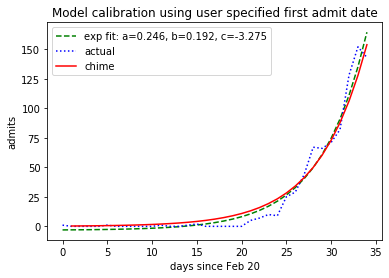

In [380]:
chime_y_fd = np.array(fd20200220_df.hospitalized)[:len(x)]
plt.plot(x, func(x, *popt), 'g--',
         label='exp fit: a={:5.3f}, b={:5.3f}, c={:5.3f}'.format(*popt))
plt.plot(x, y, 'b:', label = 'actual')
plt.plot(x, chime_y_fd, 'r-', label = 'chime')
plt.title('Model calibration using user specified first admit date')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.savefig("model_calibration_fd20200220.png")
plt.show()

### Great, results still look good..
Are predictions identical? Seems like they should be. For the first date approach, chime said implied doubling was 4.0, but of course that's with a different time 0.

In [381]:
chime_y_dt - chime_y_fd

array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

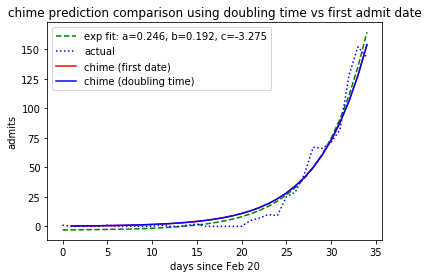

In [382]:
plt.plot(x, func(x, *popt), 'g--',
         label='exp fit: a={:5.3f}, b={:5.3f}, c={:5.3f}'.format(*popt))
plt.plot(x, y, 'b:', label = 'actual')
plt.plot(x, chime_y_fd, 'r-', label = 'chime (first date)')
plt.plot(x, chime_y_dt, 'b-', label = 'chime (doubling time)')
plt.title('chime prediction comparison using doubling time vs first admit date')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.savefig("model_calibration_btvsfd.png")
plt.show()

## Moving forward
As our hospital system is going to be running up against capacity constraints very soon, we are trying to develop **finite capacity models** to help with the tactical decisions needed during this upcoming phase. We'll share whatever we come up with at https://github.com/misken/c19.

A few other nice to have things that I'm working on are:

- with one of the earlier versions I created a tailored version of the CLI as well as a way to evaluate hundreds of scenarios quickly by iterating over ranges of inputs and using models.py as a library. Since CLI still changing, don't really want to do this but will create a wrapper of some sort so that we can easily add some custom inputs A few simple such inputs are a scenario (str) label and output path (used to use the --prefix arg as a workaround but that seems to have vanished). We like to try out numerous scenarios on a given date and so just labelling with date isn't sufficient.
- wondering if the fact that social distancing practices likely changed when our state when into shelter in place model on March 23 has any practical impact on model projections going forward. Each state (or even more local) would have their own date as to when social distancing really kicked in. May try to extend early growth stage model to capture this nuance.

Thank you everyone at the [CodeForPhilly CHIME project](https://codeforphilly.org/projects/chime) and at [UPenn's Predictive Healthcare group](http://predictivehealthcare.pennmedicine.org/). 